In [1]:
# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import os
import glob
import imageio
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 2

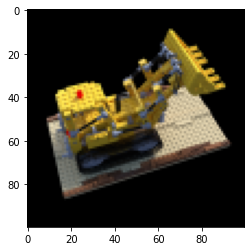

In [22]:
file_name = "tiny_nerf_data.npz"
url = "https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz"
if not os.path.exists(file_name):
    data = keras.utils.get_file(fname=file_name, origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

Camera poses taken for the considering object for illustration purposes.

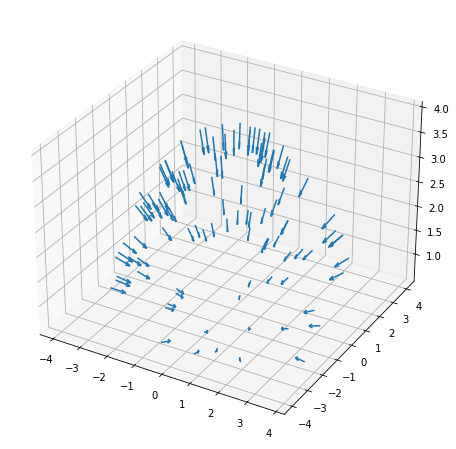

In [34]:
outward_vec = np.array([0,0,-1]).reshape((3, 1))

dir_matrices = []
origin_coords = []

for data in poses:
    transform_matix = data
    r_mat = transform_matix[:3, :3]

    dir_vec = np.dot(r_mat, outward_vec) 
    dir_matrices.append(dir_vec)

    o_vec = transform_matix[:3, -1:]
    origin_coords.append(o_vec)


dir_matrices = np.array(dir_matrices)
origin_coords = np.array(origin_coords)

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')

_ = ax.quiver(origin_coords[:, 0],
              origin_coords[:, 1],
              origin_coords[:, 2],
              dir_matrices[:, 0],
              dir_matrices[:, 1],
              dir_matrices[:, 2], length=0.5, normalize=True)
plt.show()